## IMPORTING THE REQUIRED LIBRARIES

In [1]:
import pandas as pd ; import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

## DISABLING THE SETTING WITH COPY WARNING

In [2]:
pd.options.mode.chained_assignment = None

## IMPORTING DATA

In [3]:
def importData(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

faces = importData('../preprocessing/data/facesDataClean.csv')

## ENCODING THE GENDER COLUMN INTO ZEROS AND ONES

In [4]:
def encodingTarget(dataframe: pd.DataFrame, target: str) -> (pd.DataFrame, LabelEncoder):
    
    encoder = LabelEncoder().fit(dataframe[target])
    dataframe[target] = encoder.transform(dataframe[target])

    return dataframe, encoder

faces, genderEncoder = encodingTarget(faces, 'gender')

## PREPARING THE PIXELS COLUMN FOR THE NEURAL NETWORK

In [5]:
def formatPixels(pixels: str) -> np.array:

    pixelsArray = np.array(pixels.split(), 'float64')
    pixelsArrayReshaped = np.reshape(pixelsArray, (48, 48))
    pixelsNormalized = pixelsArrayReshaped / 255.0

    return pixelsNormalized

faces['pixels'] = faces['pixels'].apply(formatPixels)

## PERFORMING THE X-Y TRAIN-TEST SPLIT

In [6]:
def split(dataframe, pixels, gender):

    X = dataframe[pixels]
    y = dataframe[gender]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split(faces, 'pixels', 'gender')

## PERFORMING THE FINAL RESHAPE IN THE IMAGES PIXELS

In [7]:
X_train = np.reshape(X_train.to_list(), (len(X_train), 48, 48, 1)) / 255.0
X_test = np.reshape(X_test.to_list(), (len(X_test), 48, 48, 1)) / 255.0

## DEFINING AND COMPILING THE STRUCTURE OF THE NEURAL NETWORK

In [8]:
def neuralNetwork():

    model = Sequential()
    model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same', input_shape = (48, 48, 1)))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = SGD(0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

genderClassifier = neuralNetwork()

## DEFINING THE VALUES FOR THE EARLY STOPPING AND THE LR AIMING TO REDUCE THE OVERFITTING

In [9]:
earlyStop = EarlyStopping(monitor = 'val_accuracy', patience = 3)
reduceLR = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 1, min_lr = 0.000001)

## TRAINING THE NEURAL NETWORK IN THE TRAINING DATA

In [10]:
genderClassifierFit = genderClassifier.fit(X_train, y_train, validation_data = (X_test, y_test),
                                           epochs = 20, callbacks = [reduceLR, earlyStop], verbose = 0)

## GENERATING THE PREDICTIONS FOR TRAINING AND TESTING IMAGES

In [11]:
trainPredictionsArray = genderClassifier.predict(X_train)
testPredictionsArray = genderClassifier.predict(X_test)

trainPredictions = [int(round(trainPrediction[0], 0)) for trainPrediction in trainPredictionsArray]
testPredictions = [int(round(testPrediction[0], 0)) for testPrediction in testPredictionsArray]

## CREATING THE CONFUSION MATRIX FOR THE TRAINING AND TESTING IMAGES

In [12]:
trainMatrix = confusion_matrix(y_train, trainPredictions)
testMatrix = confusion_matrix(y_test, testPredictions)

## EVALUATING THE PERFORMANCE OF THE NEURAL NETWORK IN THE TRAINING AND TESTING IMAGES

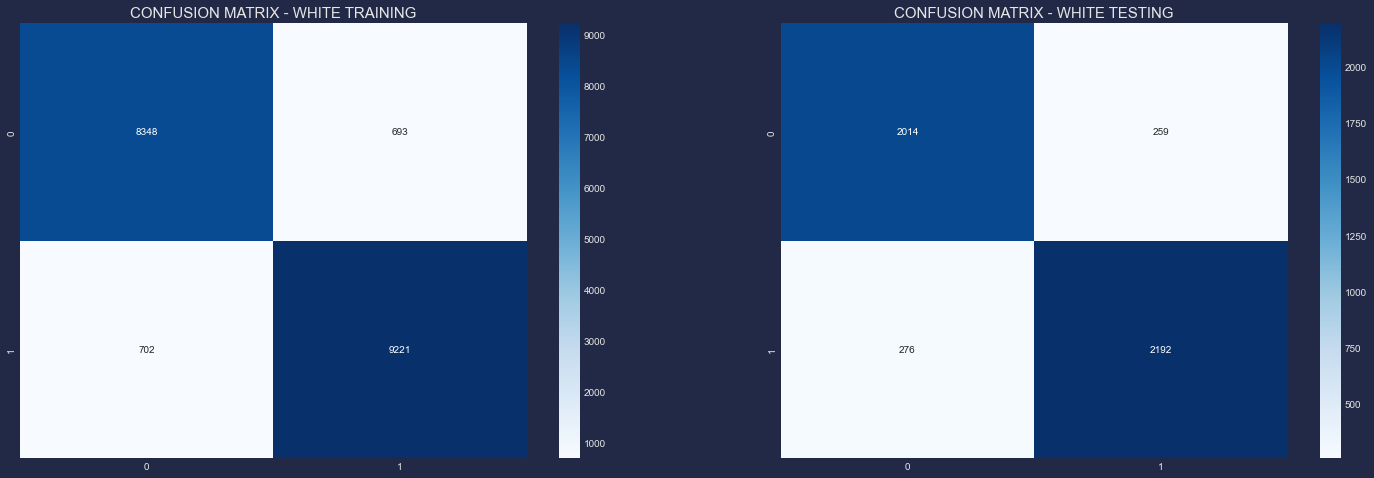

In [13]:
plt.style.use("cyberpunk")

fig, axes = plt.subplots(1, 2, figsize = (25, 8))

sns.heatmap(ax = axes[0], data = trainMatrix, annot = True, fmt = 'g', cmap = 'Blues')
sns.heatmap(ax = axes[1], data = testMatrix, annot = True, fmt = 'g', cmap = 'Blues')

axes[0].set_title('CONFUSION MATRIX - TRAINING DATA', fontsize = 15)
axes[1].set_title('CONFUSION MATRIX - TESTING DATA', fontsize = 15)

plt.show()

## EXTRACTING THE RESULTS OF THE MODEL IN THE TRAINING AND THE TESTING IMAGES

In [14]:
def model_metrics(target, predictions, data):

    accuracy = accuracy_score(target, predictions)
    precision = precision_score(target, predictions)
    recall = recall_score(target, predictions)
    f1 = f1_score(target, predictions)

    return list([data, accuracy, precision, recall, f1])

trainingTestingResults = list()

trainingTestingResults.append(model_metrics(y_train, trainPredictions, 'Train images'))
trainingTestingResults.append(model_metrics(y_test, testPredictions, 'Test images'))

imagesResults = pd.DataFrame(data = trainingTestingResults, columns = ['Data', 'Accuracy', 'Precision', 'Recall', 'F1'])

formatImagesResults = imagesResults.melt(id_vars = 'Data').rename(columns = str.title)

## EVALUATING THE METRICS IN THE TRAINING AND THE TESTING IMAGES

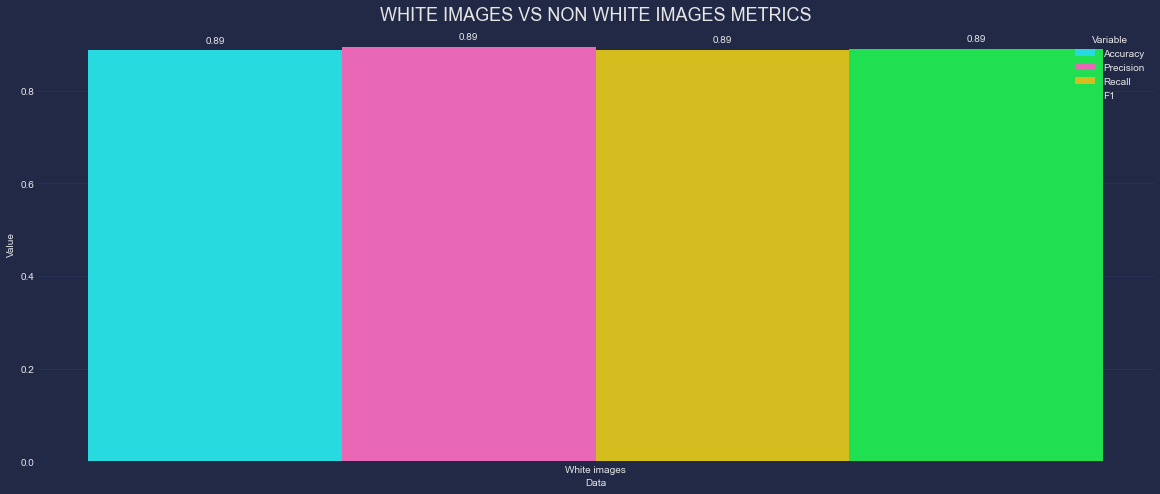

In [15]:
fig, axes = plt.subplots(figsize = (20, 8))

plt.title('TRAINING VS TESTING IMAGES - METRICS', fontsize = 18)
sns.barplot(x = 'Data', y = 'Value', hue = 'Variable', data = formatImagesResults)

for patch in axes.patches:
    axes.annotate(format(patch.get_height(), '.2f'), (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

mplcyberpunk.add_glow_effects()

plt.show()